## Bin Clustering

In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import urllib.request
import pybedtools
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

import cytograph as cg
from cytograph.decomposition import HPF
from scipy.stats import poisson
from cytograph.manifold import BalancedKNN
from cytograph.metrics import jensen_shannon_distance
from cytograph.embedding import tsne
from cytograph.clustering import PolishedLouvain, PolishedSurprise
from cytograph.plotting import manifold

sys.path.append('/home/camiel/chromograph/')
from chromograph.plotting.UMI_plot import UMI_plot

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

In [9]:
## Parameters
f = '/data/proj/scATAC/chromograph/mouse_test/10X_test_10kb.loom'
outdir = '/data/proj/scATAC/chromograph/mouse_test/'

In [5]:
import logging

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [6]:
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [10]:
ds = loompy.connect(f)
print(ds.shape)

(271145, 4273)


In [11]:
blayer = '{}kb_bins'.format(int(ds.attrs['bin_size'] / 1000))
blayer

'10kb_bins'

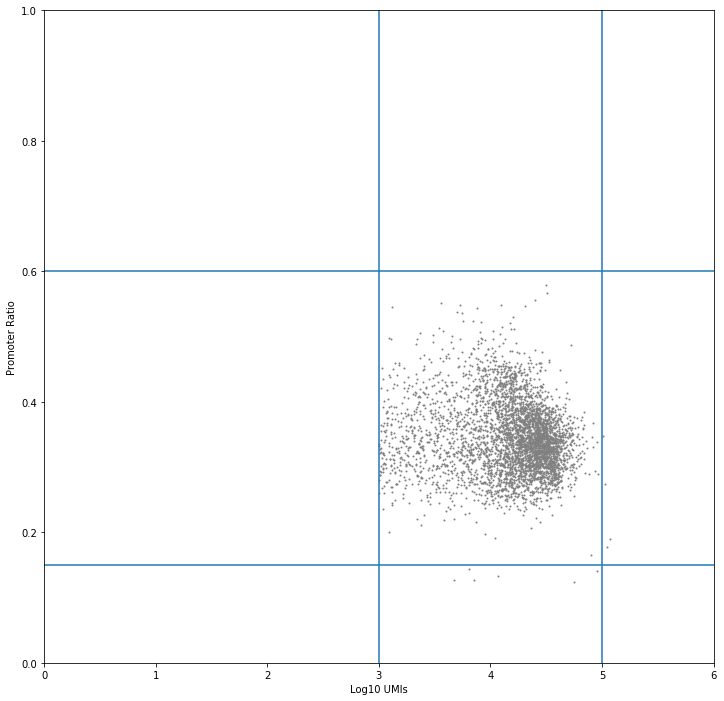

In [12]:
## --- TO BE ADDED, CURRENTLY USING CELLRANGER DEFAULT FILTERS ---
## Remove outlier cells

UMIs = np.log10(ds.ca['passed_filters'] + 1)
Prom_rat = (ds.ca['promoter_region_fragments'] + 1) / (ds.ca['passed_filters'] + 1)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(UMIs, Prom_rat, s=1, c='grey')
ax.set_xlabel('Log10 UMIs')
ax.set_ylabel('Promoter Ratio')

plt.axvline(x=3)
plt.axvline(x=5)
plt.axhline(0.15)
plt.axhline(0.60)

ax.set_xlim((0,6))
ax.set_ylim((0,1))

ds.ca['_Valid'] = np.logical_and(UMIs > 3, UMIs < 5)

961.0


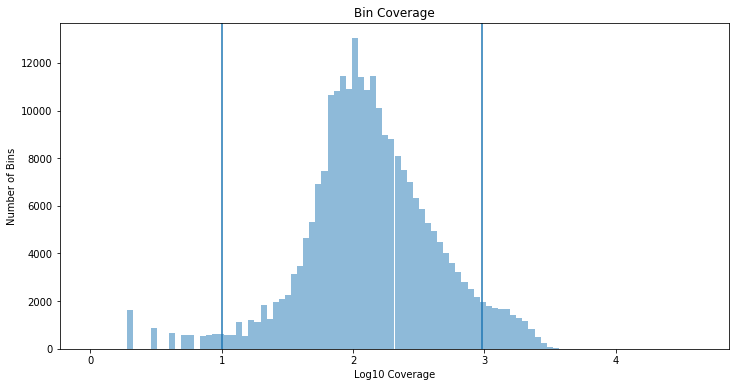

In [33]:
## Select valid bins
## --- This must be consistent between all experiments if data is to be compared
## --- Formalize this later

## nonzero (nnz) counts per bin
ds.ra['NCells'] = ds.map([np.count_nonzero], axis=0)[0]
nnz_l = np.log10(ds.ra['NCells'] + 1)
bin_cutoff = np.quantile(nnz, 0.99)
print(bin_cutoff)

plt.figure(figsize=(12,6))

plt.hist(nnz_l[nnz > 0], bins=100, alpha=0.5, range=(0, np.log10(ds.shape[1])+0.5))
plt.title("Bin Coverage")
plt.ylabel("Number of Bins")
plt.xlabel("Log10 Coverage")
plt.axvline(x=np.log10(bin_cutoff))
plt.axvline(x=1)

Text(0.5, 0, 'Number of positive bins')

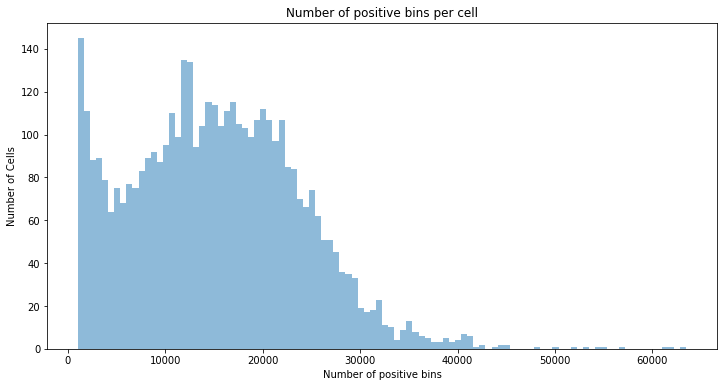

In [34]:
ds.ca['NBins'] = ds.map([np.count_nonzero], axis=1)[0]

plt.figure(figsize=(12,6))

# plt.hist(ds.ca['NBins'], bins=100, alpha=0.5, range=(0, max(ds.ca['NBins'])*1.1))
plt.hist(ds.ca['NBins'], bins=100, alpha=0.5)
plt.title("Number of positive bins per cell")
plt.ylabel("Number of Cells")
plt.xlabel("Number of positive bins")
# plt.axvline(x=np.log10(bin_cutoff))
# plt.axvline(x=1)


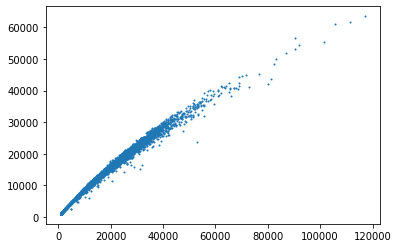

In [64]:
plt.scatter(ds.ca['passed_filters'], ds.ca['NBins'], s=1)

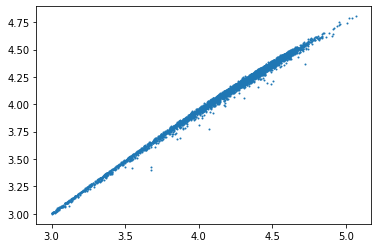

In [65]:
plt.scatter(np.log10(ds.ca['passed_filters']), np.log10(ds.ca['NBins']), s=1)

Text(0.5, 0, 'Number of positive bins')

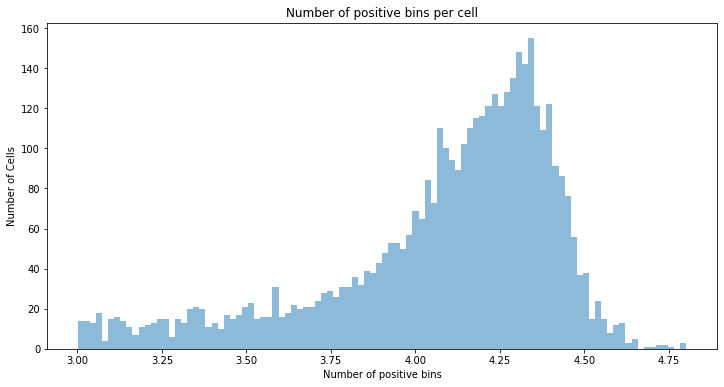

In [38]:
plt.figure(figsize=(12,6))

# plt.hist(ds.ca['NBins'], bins=100, alpha=0.5, range=(0, max(ds.ca['NBins'])*1.1))
plt.hist(np.log10(ds.ca['NBins']), bins=100, alpha=0.5)
plt.title("Number of positive bins per cell")
plt.ylabel("Number of Cells")
plt.xlabel("Number of positive bins")
# plt.axvline(x=np.log10(bin_cutoff))
# plt.axvline(x=1)

In [46]:
## Select the bins that pass filtering
bins = np.logical_and(nnz > 10, nnz < bin_cutoff)
print(sum(bins))

232016


## HPF factorization

In [47]:
## Create binary layer
ds.layers[blayer] = np.clip(ds[:,:], 0, 1)

In [48]:
# Load the data for the selected genes
data = ds[blayer].sparse(rows=bins).T
data

<4273x232016 sparse matrix of type '<class 'numpy.int64'>'
	with 43894665 stored elements in COOrdinate format>

In [49]:
# HPF factorization
hpf = HPF(k=96, validation_fraction=0.05, min_iter=10, max_iter=200, compute_X_ppv=False, n_threads=8)
hpf.fit(data)

13:35:26 INFO     HPF to 96 factors using 8 threads


HPF (nnz=41,699,931):  20%|█▉        | 40/201 [1:37:17<6:31:37, 145.95s/it, diff=-.00133, ll=-5.68e+6]


In [50]:
logging.info("Adding Betas and Thetas to loom file")
beta_all = np.zeros((ds.shape[0], hpf.beta.shape[1]))
beta_all[bins] = hpf.beta
# beta_all = hpf.beta
# Save the unnormalized factors
ds.ra.HPF_beta = beta_all
ds.ca.HPF_theta = hpf.theta
# Here we normalize so the sums over components are one, because JSD requires it
# and because otherwise the components will be exactly proportional to cell size
theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
beta = (hpf.beta.T / hpf.beta.sum(axis=1)).T
beta_all[bins] = beta
# beta_all = beta
# Save the normalized factors
ds.ra.HPF = beta_all
ds.ca.HPF = theta

15:13:30 INFO     Adding Betas and Thetas to loom file


In [51]:
logging.info("Calculating posterior probabilities")

# Expected values
exp = "{}_expected".format(blayer)
n_samples = ds.shape[1]

ds[exp] = 'float32'  # Create a layer of floats
log_posterior_proba = np.zeros(n_samples)
theta_unnormalized = hpf.theta
data = data.toarray()
start = 0
batch_size = 6400
beta_all = ds.ra.HPF_beta  # The unnormalized beta

while start < n_samples:
    # Compute PPV (using normalized theta)
    ds[exp][:, start: start + batch_size] = beta_all @ theta[start: start + batch_size, :].T
    # Compute PPV using raw theta, for calculating posterior probability of the observations
    ppv_unnormalized = beta @ theta_unnormalized[start: start + batch_size, :].T
    log_posterior_proba[start: start + batch_size] = poisson.logpmf(data.T[:, start: start + batch_size], ppv_unnormalized).sum(axis=0)
    start += batch_size
ds.ca.HPF_LogPP = log_posterior_proba

15:13:33 INFO     Calculating posterior probabilities


## Nearest neighbor graph

In [52]:
logging.info("Constructing nearest-neighbor graph")

bnn = BalancedKNN(k=25, metric="js", maxl=2 * 25, sight_k=2 * 25, n_jobs=-1)
bnn.fit(theta)
knn = bnn.kneighbors_graph(mode='distance')
knn.eliminate_zeros()
mknn = knn.minimum(knn.transpose())
# Convert distances to similarities
knn.data = 1 - knn.data
mknn.data = 1 - mknn.data
ds.col_graphs.KNN = knn
ds.col_graphs.MKNN = mknn
# Compute the effective resolution
d = 1 - knn.data
d = d[d < 1]
radius = np.percentile(d, 90)
ds.attrs.radius = radius
knn = knn.tocoo()
knn.setdiag(0)
inside = knn.data > 1 - radius
rnn = sparse.coo_matrix((knn.data[inside], (knn.row[inside], knn.col[inside])), shape=knn.shape)
ds.col_graphs.RNN = rnn

15:32:33 INFO     Constructing nearest-neighbor graph
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../anaconda3/envs/chromograph/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


## Embeddings

In [53]:
## Perform tSNE and UMAP
logging.info("Generating tSNE from thetas")
ds.ca.TSNE = tsne(theta, metric="js", radius=radius)

logging.info("Generating UMAP from thetas")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)  # Suppress an annoying UMAP warning about meta-embedding
    ds.ca.UMAP = UMAP(n_components=2, metric=jensen_shannon_distance, n_neighbors=25 // 2, learning_rate=0.3, min_dist=0.25).fit_transform(theta)

logging.info("Generating 3D UMAP from thetas")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ds.ca.UMAP3D = UMAP(n_components=3, metric=jensen_shannon_distance, n_neighbors=25 // 2, learning_rate=0.3, min_dist=0.25).fit_transform(theta)

15:32:58 INFO     Generating tSNE from thetas
15:33:47 INFO     Generating UMAP from thetas
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/chromograph/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.p

## Clustering

In [54]:
logging.info("Performing Polished Louvain clustering")
pl = PolishedLouvain(outliers=False)
labels = pl.fit_predict(ds, graph="RNN", embedding="UMAP3D")
ds.ca.ClustersModularity = labels + min(labels)
ds.ca.OutliersModularity = (labels == -1).astype('int')
ds.ca.Clusters = labels + min(labels)
ds.ca.Outliers = (labels == -1).astype('int')

logging.info("Performing Louvain Polished Surprise clustering")
ps = PolishedSurprise(embedding="TSNE")
labels = ps.fit_predict(ds)
ds.ca.ClustersSurprise = labels + min(labels)
ds.ca.OutliersSurprise = (labels == -1).astype('int')
logging.info(f"Found {ds.ca.Clusters.max() + 1} clusters")

15:34:31 INFO     Performing Polished Louvain clustering
15:34:31 INFO     Louvain community detection
15:34:42 INFO     Marking tiny clusters as outliers
15:34:42 INFO     Using DBSCAN to mark outliers
15:34:42 INFO     Using neighborhood to mark outliers
15:34:43 INFO     Breaking clusters
15:34:44 INFO     Smoothing cluster identity on the embedding
15:34:45 INFO     Performing Louvain Polished Surprise clustering
15:34:46 INFO     Found 8 clusters


## Visualisations

16:07:46 INFO     Plotting UMAP
16:07:50 INFO     Plotting TSNE
16:07:54 INFO     plotting the number of UMIs


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

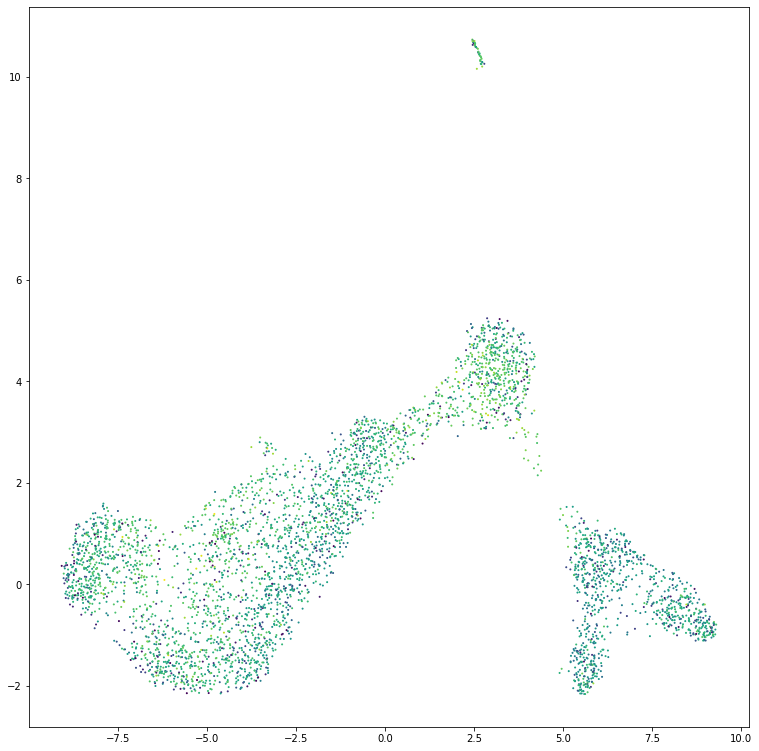

In [73]:
logging.info("Plotting UMAP")
manifold(ds, os.path.join(outdir, 'manifold_UMAP.png'), embedding = 'UMAP')
logging.info("Plotting TSNE")
manifold(ds, os.path.join(outdir, 'manifold_TSNE.png'), embedding = 'TSNE')
logging.info("plotting the number of UMIs")
UMI_plot(ds, os.path.join(outdir, 'manifold_UMI.png'), embedding = 'UMAP')

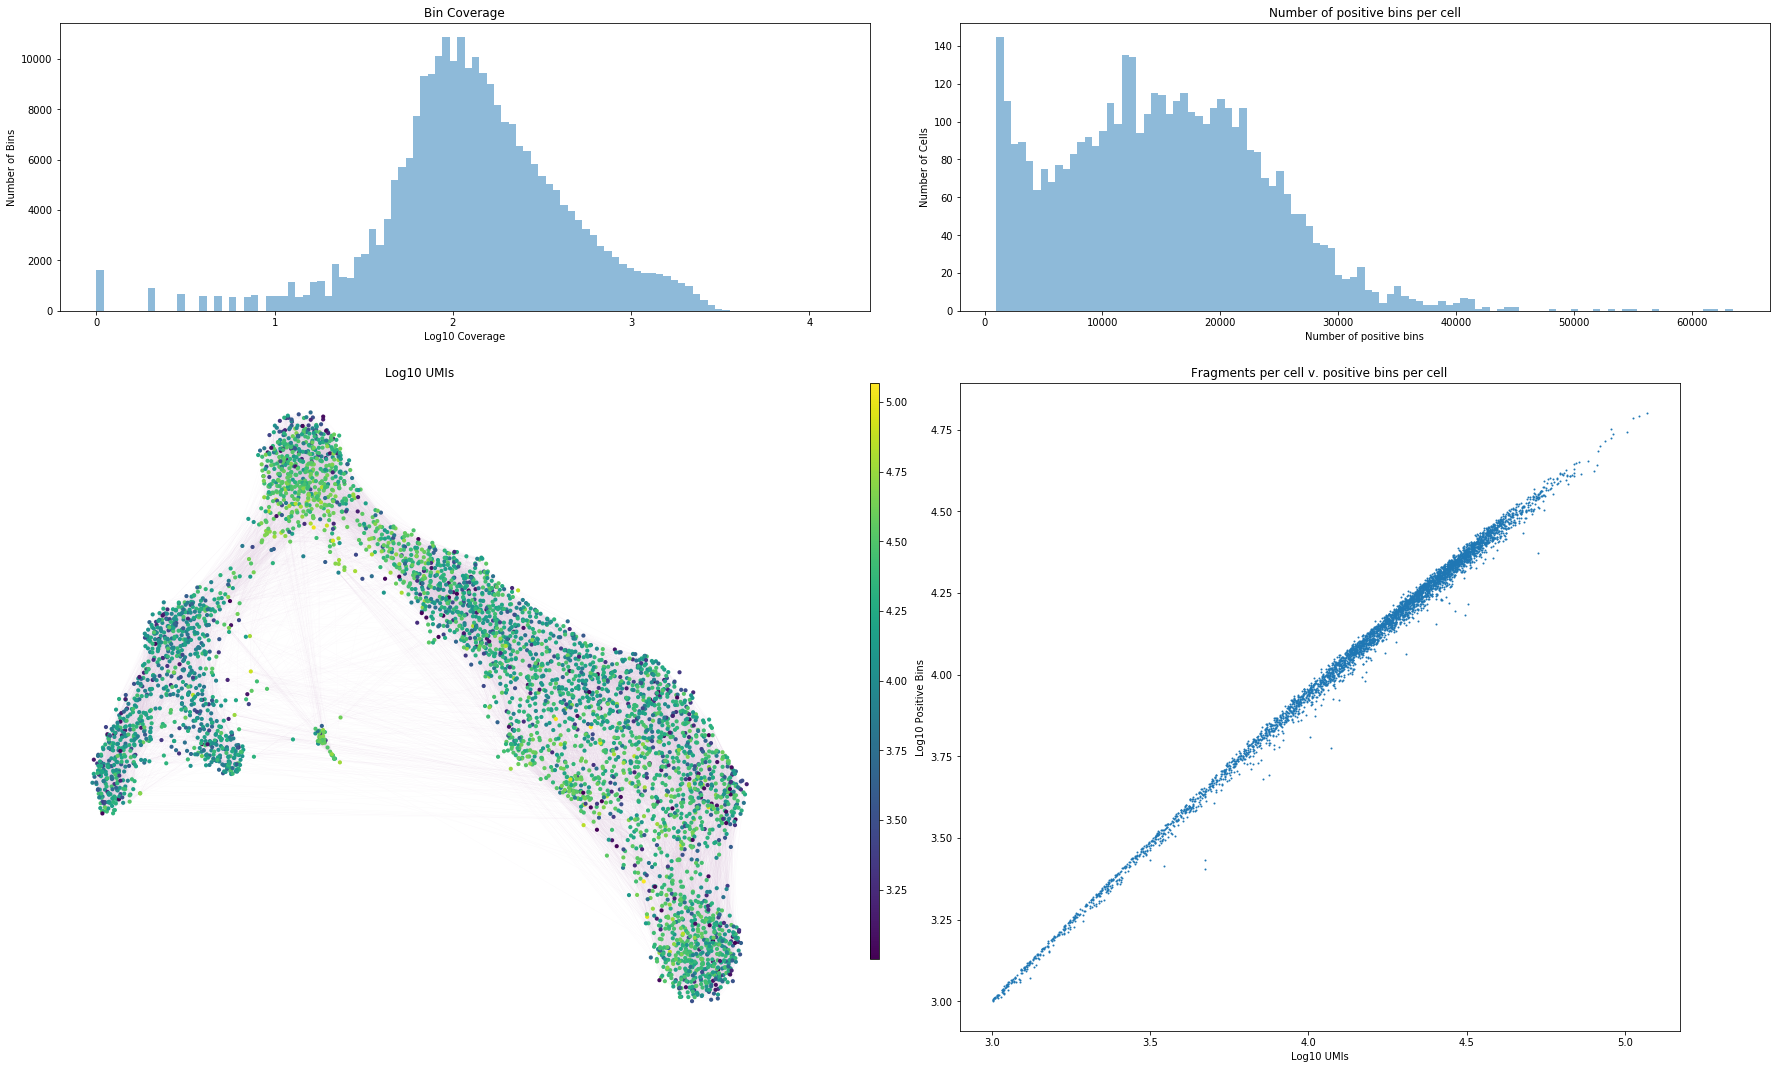

In [69]:
## Add functionality for NBins and histograms

def UMI_plot2(ds: loompy.LoomConnection, out_file: str, embedding: str = "TSNE") -> None:
    '''
    Used to plot the number of fragments on top of the manifold
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    fig = plt.figure(figsize=(25, 20))
    ax = fig.add_axes([0, 0, 0.40, 0.45])
    
    # Draw edges
    if has_edges:
        lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
        ax.add_collection(lc)
    
    im = ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='viridis', c=np.log10(ds.ca['passed_filters']), marker='.', lw=0, s=epsilon)
    
    cax = fig.add_axes([0.45, 0.05, 0.005, 0.4])
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Log10 UMIs')
    ax.axis("off")
    
    ## Histogram of Bin Coverage
    ax2 = fig.add_axes([0, 0.5, 0.45, 0.2])

    ax2.hist(np.log10(ds.ra['NCells'][ds.ra['NCells'] > 0]), bins=100, alpha=0.5, range=(0, np.log10(ds.shape[1])+0.5))
    ax2.set_title("Bin Coverage")
    ax2.set_ylabel("Number of Bins")
    ax2.set_xlabel("Log10 Coverage")
    
    ## Histogram of Bins per cell
    ax3 = fig.add_axes([0.5, 0.5, 0.45, 0.2])
    
    ax3.hist(ds.ca['NBins'], bins=100, alpha=0.5)
    ax3.set_title("Number of positive bins per cell")
    ax3.set_ylabel("Number of Cells")
    ax3.set_xlabel("Number of positive bins")
    
    ax4 = fig.add_axes([0.5, 0, 0.40, 0.45])
    ax4.scatter(np.log10(ds.ca['passed_filters']), np.log10(ds.ca['NBins']), s=1)
    ax4.set_title("Fragments per cell v. positive bins per cell")
    ax4.set_ylabel("Log10 Positive Bins")
    ax4.set_xlabel("Log10 UMIs")
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

UMI_plot2(ds, os.path.join(outdir, 'plots_UMI.png'), embedding = 'UMAP')